In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import find_peaks
from itertools import groupby

### Load image

(2287, 440, 3)

<Figure size 1440x2880 with 0 Axes>

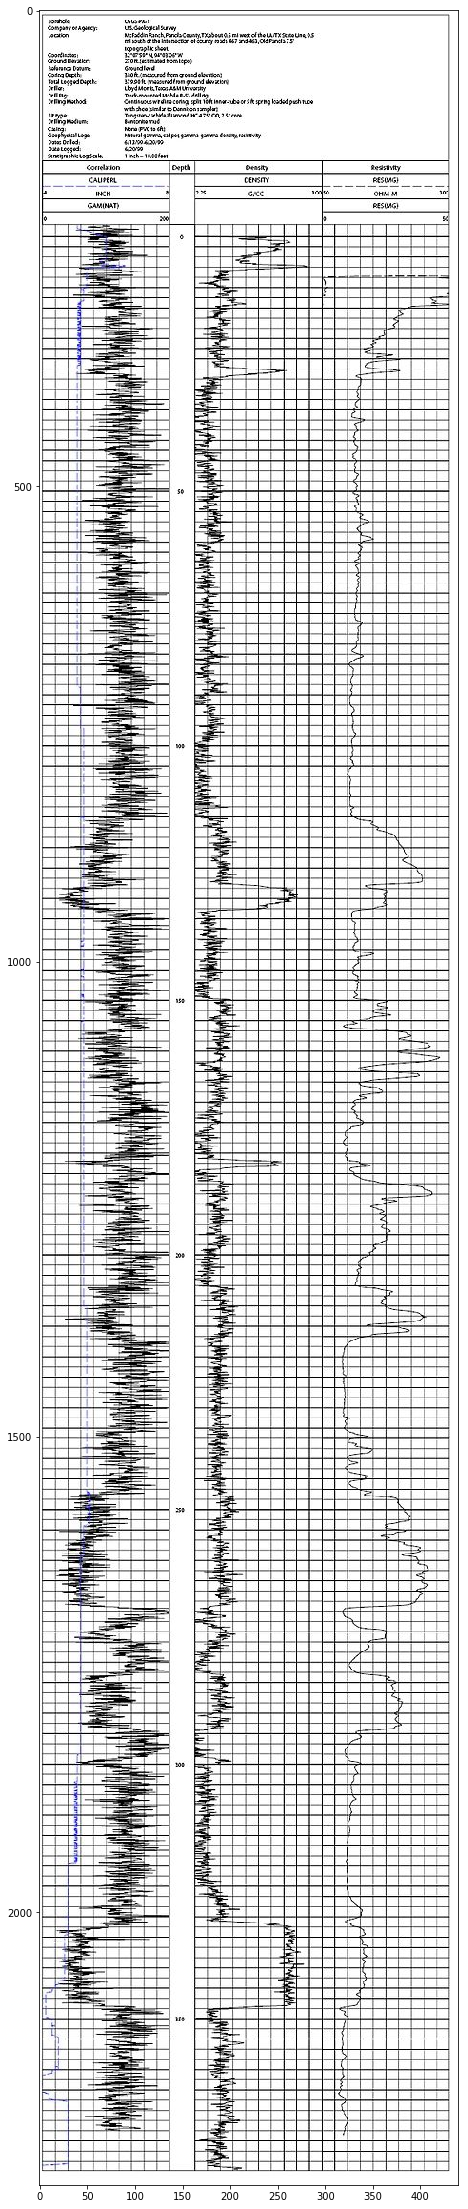

In [2]:
src = cv2.imread('../data/fieldprint.jpg'); src.shape
###
# OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. 
# When you display an image loaded with OpenCv in matplotlib the channels will be back to front.
# The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB
###

plt.figure(figsize=(20,40))
_ = plt.imshow(src)

### BGR to Gray scale

In [3]:
# Transform source image to gray if it is not already
if len(src.shape) != 2:
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
else:
    gray = src

<Figure size 1440x2880 with 0 Axes>

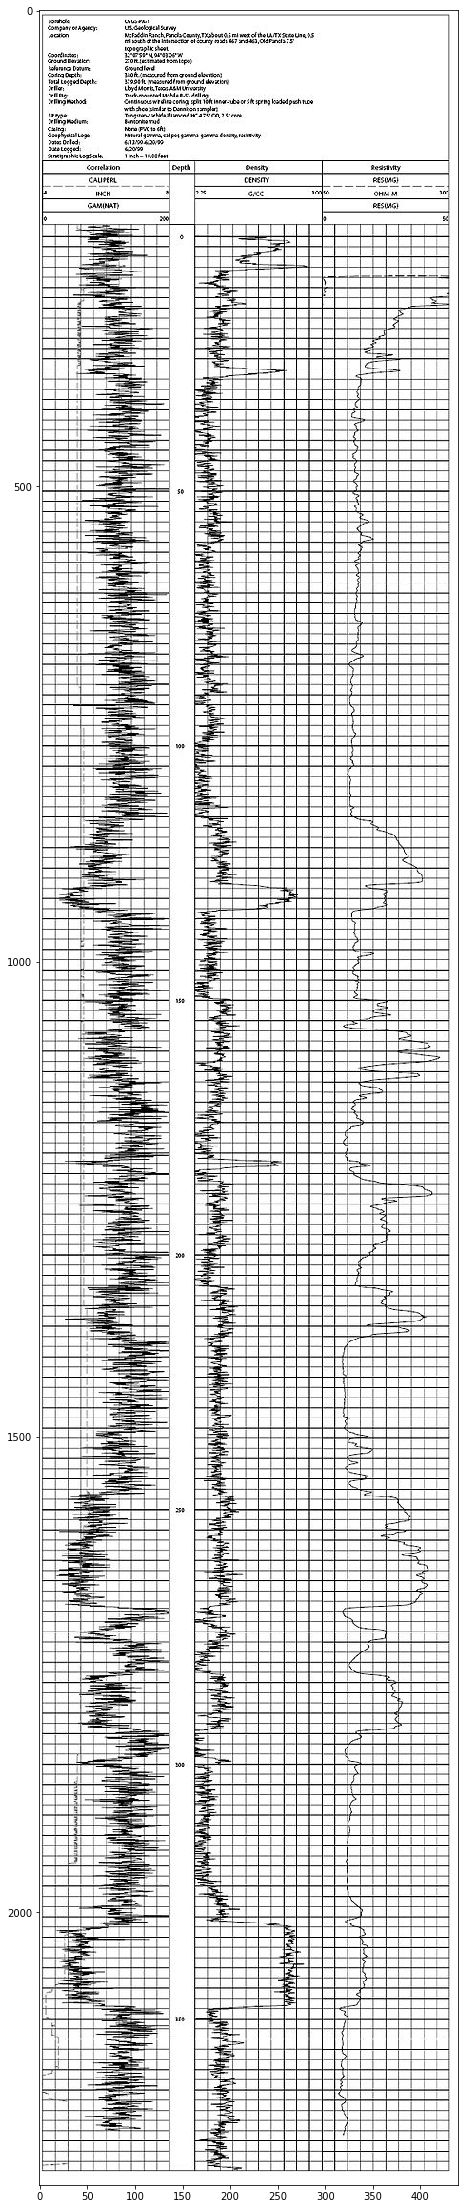

In [4]:
plt.figure(figsize=(20,40))
_ = plt.imshow(gray, cmap='gray')

### Gray scale to Binary

In [5]:
# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv2.bitwise_not(gray)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)

<Figure size 1440x2880 with 0 Axes>

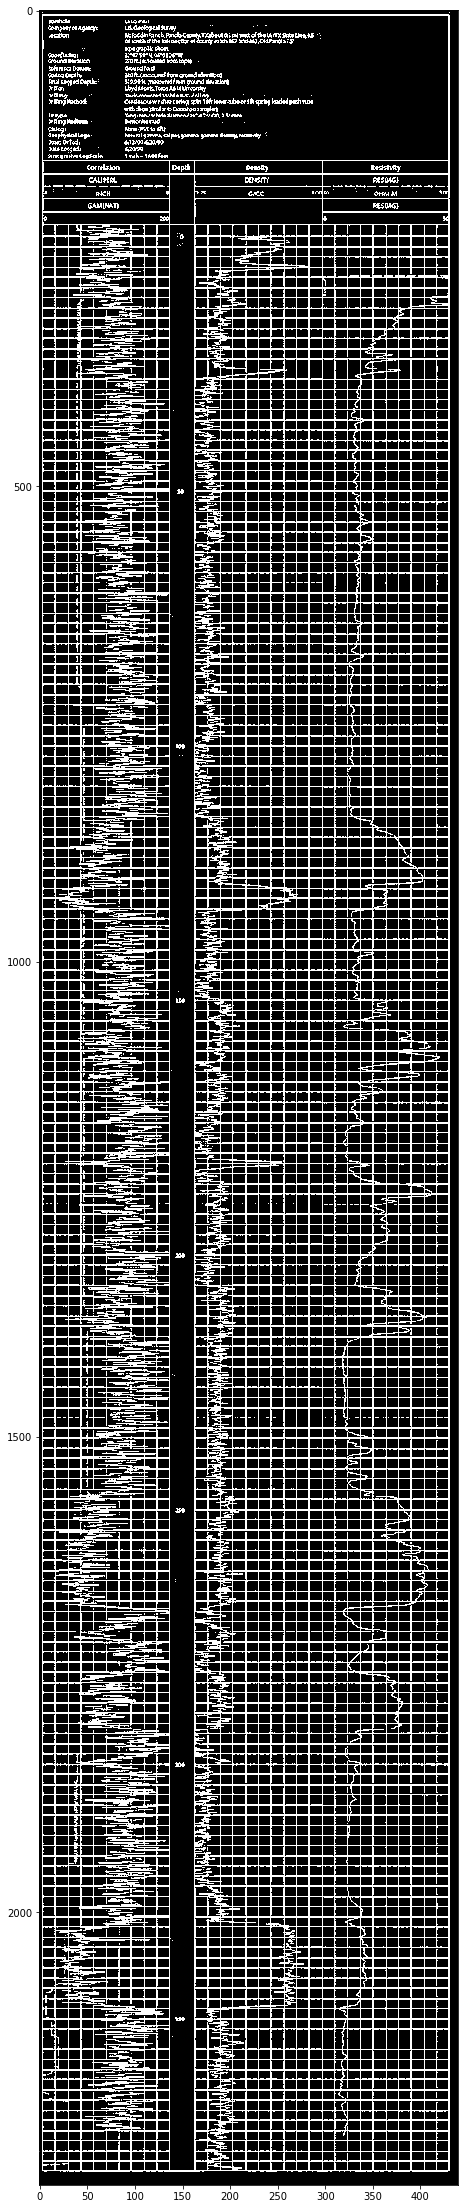

In [6]:
plt.figure(figsize=(20,40))
_ = plt.imshow(bw, cmap='gray')

### Histogram

In [7]:
bw.shape
vertSum = np.sum(bw,0)
horzSum = np.sum(bw,1)

(2287, 440)

<Figure size 1440x360 with 0 Axes>

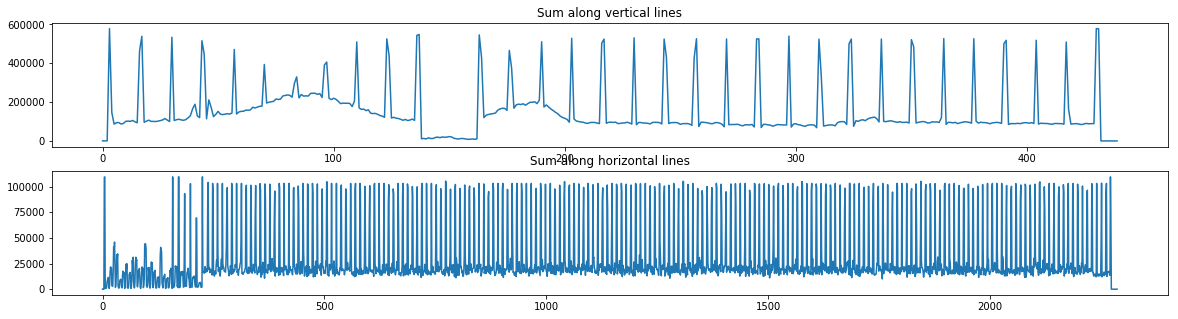

In [8]:
plt.figure(figsize=(20, 5))

_ = plt.subplot(2,1,1)
_ = plt.plot(vertSum)
_ = plt.title('Sum along vertical lines')

_ = plt.subplot(2,1,2)
_ = plt.plot(horzSum)
_ = plt.title('Sum along horizontal lines')

### Find Peaks

<Figure size 1440x360 with 0 Axes>

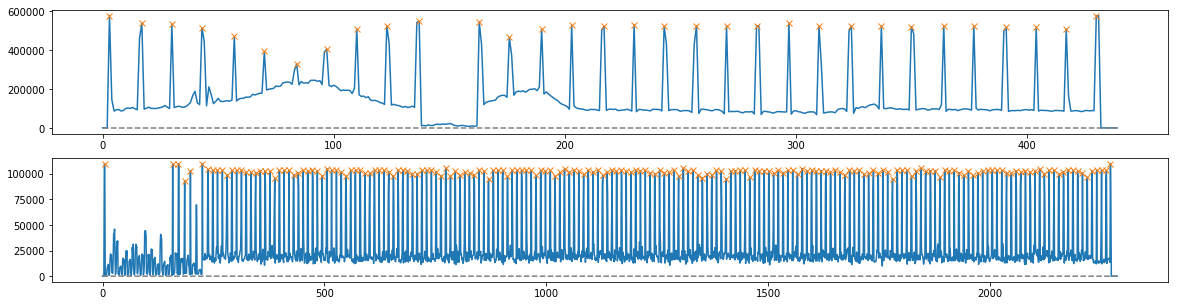

In [9]:
plt.figure(figsize=(20, 5))

v = vertSum.copy();
v_peaks, _ = find_peaks(v, distance=10, height=200000); 
_ = plt.subplot(2,1,1)
_ = plt.plot(v)
_ = plt.plot(v_peaks, v[v_peaks], "x")
_ = plt.plot(np.zeros_like(v), "--", color="gray")

h = horzSum.copy();
h_peaks, _ = find_peaks(h, height=75000); 
_ = plt.subplot(2,1,2)
_ = plt.plot(h)
_ = plt.plot(h_peaks, h[h_peaks], "x")
_ = plt.plot(np.zeros_like(h), "--", color="gray")


### Find areas with many lines

In [24]:
def getDiffMask(peaks, lower, upper):
    peaks_diff = np.diff(peaks); print(peaks_diff)
    peaks_diff_mask = np.greater(peaks_diff, lower) & np.less(peaks_diff, upper)
    
    return(peaks_diff_mask)

### Get areas with many horizontal lines

In [45]:
h = horzSum.copy()
h_peaks, _ = find_peaks(h, height=75000); #print(h_peaks);
lower = 8
upper = 12

h_peaks_diff_mask = getDiffMask(h_peaks, lower, upper); #h_peaks_diff_mask

[153  13  14  13  27  13  10  11  11  11  10  11  11  11  10  11  10  11
  11  11  10  11  11  11  10  11  10  11  11  11  10  11  11  11  10  11
  11  10  11  11  11  10  11  11  10  11  11  10  11  11  11  10  11  11
  10  11  11  11  10  11  11  10  11  11  11  10  11  11  10  11  11  10
  11  11  11  10  11  11  10  11  11  11  10  11  11  10  11  11  11  10
  11  10  11  11  11  10  11  11  11  10  11  11  10  11  11  10  11  11
  11  10  11  11  10  11  11  11  10  11  11  10  11  11  11  10  11  11
  10  11  11  11  10  11  11  10  11  11  10  11  11  11  10  11  11  11
  10  11  11  10  11  11  10  11  11  11  10  11  11  10  11  11  11  10
  11  11  11  10  10  11  11  11  11  10  11  11  11  10  11  10  11  11
  11  10  11  11  11  10  11  11  10  11  11  10  11  11  11   9]


### Get areas with many vertical lines

In [33]:
v = vertSum.copy()
v_peaks, _ = find_peaks(v, distance=10, height=200000)
lower = 12
upper = 15

v_peaks_diff_mask = getDiffMask(v_peaks, lower, upper); v_peaks_diff_mask

[14 13 13 14 13 14 13 13 13 14 26 13 14 13 14 13 13 14 13 13 14 13 14 13
 13 14 13 14 13 13 13]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [71]:
def getLocWithManyLines(diff_mask):
    grouped_data = groupby(enumerate(diff_mask), key=lambda x: x[-1])

    locWithManyLines = []

    for k, g in grouped_data:
        g = list(g)

        if k == True and len(g) > 8: # more than 8 consecutive lines
            locWithManyLines.append((g[0][0], g[-1][0]))

    return(locWithManyLines)   

In [70]:
locWithVertLines = getLocWithManyLines(v_peaks_diff_mask); locWithVertLines

locWithHorzLines = getLocWithManyLines(h_peaks_diff_mask); locWithHorzLines

[(0, 9), (11, 30)]

[(6, 195)]

### Display

True

<Figure size 1440x2880 with 0 Axes>

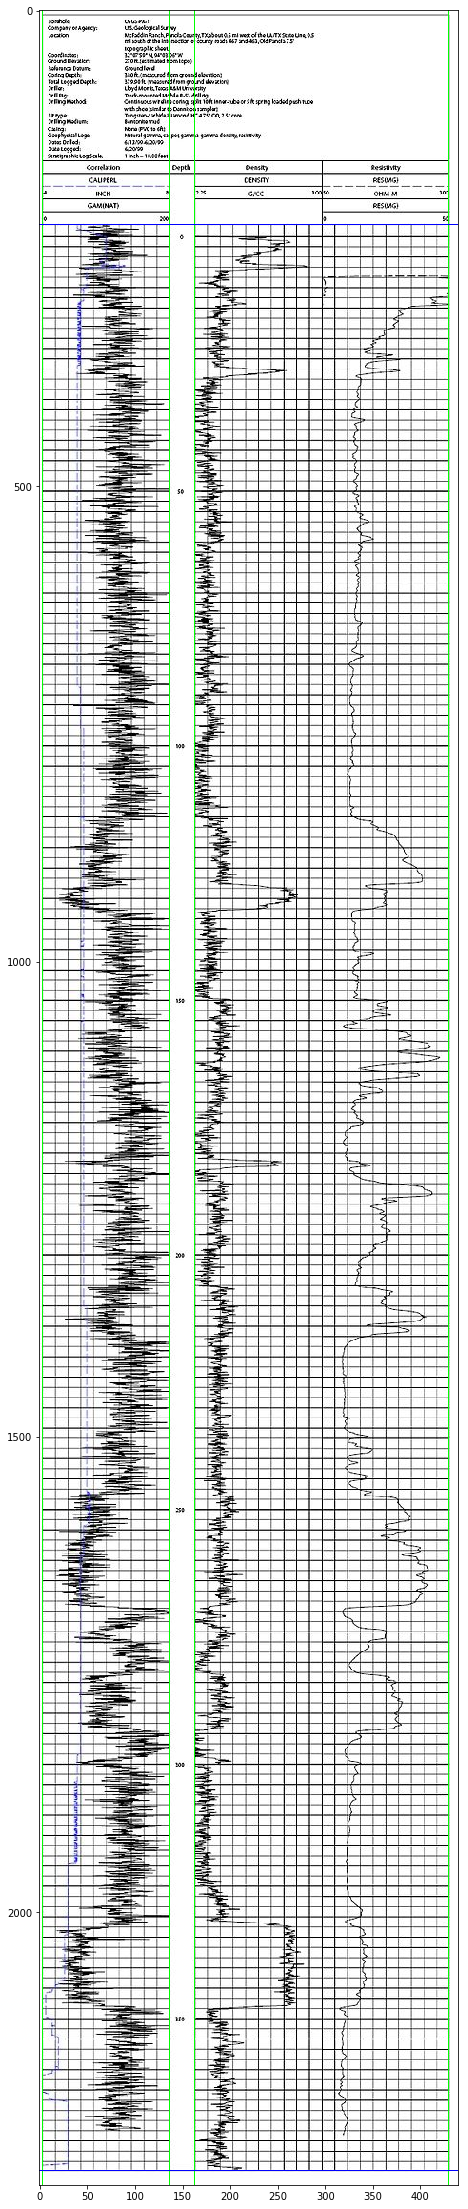

In [66]:
new = src.copy()

for item in locWithVertLines:

    new[:,v_peaks[item[0]],:] = (0,255,0)
    new[:, v_peaks[item[1]+1],:] = (0,255,0)

for item in locWithHorzLines:
    new[h_peaks[item[0]-1],:,:] = (0,0,255)
    new[h_peaks[item[1]+1],:,:] = (0,0,255)

cv2.imwrite('../data/extract_graph.jpg',new)
    
plt.figure(figsize=(20,40))
_ = plt.subplot(1,2,1)
_ = plt.imshow(new)
